In [1]:
import pandas as pd
import json

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import shap

import yaml
import os
import argparse
import sys
from datetime import datetime


## Loading

In [2]:
def prepare_categorical_variable(clinical_df, var, drop_values=None, verbose=True):
    """
    Prepares a categorical variable by mapping unique values to integers starting from 0.

    Args:
        clinical_df (pd.DataFrame): clinical data with sample index.
        var (str): variable name.
        drop_values (list): list of values to treat as NaN and exclude from mapping.
        verbose (bool): print debug info.

    Returns:
        tuple: (pd.Series with integer-encoded values, dict mapping integers to original values)
    """
    assert isinstance(clinical_df, pd.DataFrame), "clinical_df must be a DataFrame"
    assert var in clinical_df.columns, f"'{var}' not found in clinical_df"

    series = clinical_df[var].copy()

    if drop_values is not None:
        series = series.replace(drop_values, pd.NA)

    unique_vals = series.dropna().unique()
    value_to_int = {val: i for i, val in enumerate(unique_vals)}
    int_to_value = {i: val for val, i in value_to_int.items()}
    mapped_series = series.map(value_to_int)
    mapped_series = mapped_series.dropna().astype(int)


    if verbose:
        print(f"{var} unique values: {len(unique_vals)}")
        if drop_values:
            print(f"Dropped values: {drop_values}")
        print("Mapping created:")
        for i, val in int_to_value.items():
            print(f"\t{i}: {repr(val)}")


    return mapped_series, int_to_value

## Cleaning

In [3]:
def filter_features_by_missingness(X, threshold=0.2, verbose=True):
    """
    Remove protein features with too many missing values.

    Args:
        X (pd.DataFrame): samples x proteins.
        threshold (float): maximum fraction of missing values allowed (e.g., 0.2 = 20%).
        verbose (bool): print number of features removed.

    Returns:
        pd.DataFrame: filtered X with fewer columns.
    """
    missing_fraction = X.isna().mean()
    keep_cols = missing_fraction[missing_fraction <= threshold].index
    if verbose:
        dropped = len(X.columns) - len(keep_cols)
        print(f"Filtered out {dropped}/{len(X.columns)} proteins with >{threshold*100:.0f}% missing values.")
    return X[keep_cols]


In [4]:
def impute_missing_values(X, method="mean"):
    """
    Impute missing values in X.

    Args:
        X (pd.DataFrame): samples x proteins.
        method (str): "mean", "median", or "zero".

    Returns:
        pd.DataFrame: imputed X.
    """
    if method == "mean":
        return X.fillna(X.mean())
    elif method == "median":
        return X.fillna(X.median())
    elif method == "zero":
        return X.fillna(0)
    else:
        raise ValueError("Invalid imputation method. Choose from 'mean', 'median', or 'zero'.")

## Models

In [5]:
def split_classify_df(classify_df, var, test_size=0.2, random_state=42):
    '''
    Train-test split classify_df, which should have features (predictors) as columns along with a binary response variable
    '''
    # Train/test split
    y = classify_df[var].copy()
    X = classify_df.drop(columns=[var]).copy()


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [6]:
def get_multi_class_xgboost_model(X_train, y_train, seed=42):
    model = XGBClassifier(objective='multi:softprob', random_state=seed)
    model.fit(X_train, y_train)
    return model

In [7]:
def get_ovr_auroc(model, X_test, y_test):
    y_prob = model.predict_proba(X_test)
    
    # Binarize the output labels for multi-class
    y_test_binarized = label_binarize(y_test, classes=model.classes_) # This creates a OHE vector describing true class

    # Compute the AUROC
    auroc = roc_auc_score(y_test_binarized, y_prob, multi_class='ovr')

    return auroc

In [8]:
def test_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    y_test_binarized = label_binarize(y_test, classes=model.classes_)

    return y_prob, y_pred, y_test_binarized

In [9]:
def plot_roc_curves(model, y_test_binarized, y_prob, var, int_to_value, report, save_path=None):

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(model.classes_)):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves for each class
    plt.figure(figsize=(10, 8))
    colors = plt.cm.get_cmap('tab10', len(model.classes_))

    for i in range(len(model.classes_)):
        n = int(report[str(i)]["support"])
        f1 = report[str(i)]["f1-score"]
        plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
                 label=f'{int_to_value[i]} (AUC: {roc_auc[i]:.3f} | f1: {f1:.2f} | n={n})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC Curves for Multi-Class Classification (XGBoost) for '{var}'")
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()  
    plt.close()


## SHAP

In [10]:
def get_shap_values(model, X_train, X_test):
    explainer = shap.Explainer(model, X_train) 
    shap_values = explainer(X_test, check_additivity=False)
    return shap_values


In [11]:
def plot_shap_values(shap_values, X_test, model, int_to_value, var,protgroup_gene_map=None, save_path=None):
    import matplotlib.pyplot as plt
    import shap

    if protgroup_gene_map:
        genes = [str(protgroup_gene_map.get(protgroup, protgroup)).split(";")[0] for protgroup in X_test.columns]
    else:
        genes = X_test.columns

    class_names = [int_to_value[i] for i in range(len(model.classes_))]

    plt.figure()
    shap.summary_plot(shap_values, X_test, feature_names=genes, plot_type="bar", class_names=class_names, show=False)
    plt.title(f"SHAP Feature Importance on '{var}'")
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.show()
    plt.close()


## main()

In [12]:
def main(config_path):
    # Load config
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)

    # Load data
    protein_group_df = pd.read_csv(config["protein_group_csv"], index_col=0)
    clinical_df = pd.read_csv(config["clinical_csv"], index_col=0)
    protgroup_gene_map = (
        json.load(open(config["protgroup_gene_map_json"]))
        if config.get("protgroup_gene_map_json") else None
    )

    # Preprocessing
    X = protein_group_df.copy()
    X = filter_features_by_missingness(X, config["missingness_thresh"])
    X = impute_missing_values(X, config["imputation_method"])
    var = config["var"]

    y, int_to_value = prepare_categorical_variable(
        clinical_df, var, drop_values=config.get("drop_values", []))

    # Merge data
    classify_df = pd.merge(X, y, left_index=True, right_index=True)

    # Train/test split
    X_train, X_test, y_train, y_test = split_classify_df(classify_df, var, random_state=config["seed"])

    # Train model
    model = get_multi_class_xgboost_model(X_train, y_train, seed=config["seed"])
    y_prob, y_pred, y_test_binarized = test_model(model, X_test, y_test)

    # Evaluation
    ovr_auroc = get_ovr_auroc(model, X_test, y_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)


    print(f"OVR AUROC: {ovr_auroc:.3f}")

    # Output directory
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    out_dir = os.path.join(config["output_dir"], f"{var}_{timestamp}")
    os.makedirs(out_dir, exist_ok=True)

    # SHAP
    shap_values = get_shap_values(model, X_train, X_test)


    # Save ROC plot
    roc_path = os.path.join(out_dir, "roc_curves.png")
    plot_roc_curves(model, y_test_binarized, y_prob, var, int_to_value, report, save_path=roc_path)

    # Save SHAP plot
    shap_path = os.path.join(out_dir, "shap_summary.png")
    plot_shap_values(shap_values, X_test, model, int_to_value, var, protgroup_gene_map, save_path=shap_path)


    for i in int_to_value.keys():
        if str(i) in report.keys():
            report[int_to_value[i]] = report.pop(str(i))
    # Save results
    pd.DataFrame(report).transpose().to_csv(os.path.join(out_dir, "classification_report.csv"))
    pd.DataFrame(y_prob, index=y_test.index).to_csv(os.path.join(out_dir, "y_prob.csv"))
    pd.DataFrame({"y_pred": y_pred}, index=y_test.index).to_csv(os.path.join(out_dir, "y_pred.csv"))

    # Save config
    with open(os.path.join(out_dir, "config.yaml"), "w") as f:
        yaml.safe_dump(config, f)



In [53]:
# if __name__ == "__main__":
if __name__ == "__main__" and 'ipykernel' not in sys.modules:  # CLI mode
    parser = argparse.ArgumentParser(description="XGBoost Classification Pipeline")
    parser.add_argument("--config_path", type=str, required=True,
                        help="Path to config file")
    
    args = parser.parse_args()
    main(args.config_path)

if 'ipykernel' in sys.modules:  # Notebook mode
    config = {
        "protein_group_csv": "protein_group_df.csv",
        "clinical_csv": "clinical_df.csv",
        "protgroup_gene_map_json": "protgroup_gene_map.json",
        "output_dir": "xgb_results",

        "var": "Condition",  # Clinical variable to predict

        # Optional settings
        "missingness_thresh": 0.2,
        "imputation_method": "mean",
        "drop_values": None,
        "seed": 42
    }

    with open("config.yaml", "w") as f:
        yaml.dump(config, f, default_flow_style=False)

    main("config.yaml")


Filtered out 2278/8320 proteins with >20% missing values.
Condition unique values: 4
Mapping created:
	0: '1-C'
	1: '2-SC'
	2: '3-A'
	3: '4-S'
OVR AUROC: 0.654


C:\Users\neil_\AppData\Local\Temp\ipykernel_23448\3836921111.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(model.classes_))


In [16]:

main("Imputed_MatrixExport_NP_A.yaml")

Filtered out 167/2142 proteins with >20% missing values.
Condition unique values: 4
Mapping created:
	0: '1-C'
	1: '2-SC'
	2: '3-A'
	3: '4-S'
OVR AUROC: 0.614


C:\Users\neil_\AppData\Local\Temp\ipykernel_69740\3836921111.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(model.classes_))


In [15]:
main("Imputed_MatrixExport_NP_B.yaml")

Filtered out 631/3788 proteins with >20% missing values.
Condition unique values: 4
Mapping created:
	0: '1-C'
	1: '2-SC'
	2: '3-A'
	3: '4-S'
OVR AUROC: 0.674


C:\Users\neil_\AppData\Local\Temp\ipykernel_69740\3836921111.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(model.classes_))


In [14]:
main("MatrixExport_NP_A.yaml")

Filtered out 0/3054 proteins with >20% missing values.
Condition unique values: 4
Mapping created:
	0: '1-C'
	1: '2-SC'
	2: '3-A'
	3: '4-S'
OVR AUROC: 0.537


C:\Users\neil_\AppData\Local\Temp\ipykernel_69740\3836921111.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(model.classes_))


In [13]:
main("MatrixExport_NP_B.yaml")

Filtered out 0/1649 proteins with >20% missing values.
Condition unique values: 4
Mapping created:
	0: '1-C'
	1: '2-SC'
	2: '3-A'
	3: '4-S'
OVR AUROC: 0.764


C:\Users\neil_\AppData\Local\Temp\ipykernel_69740\3836921111.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(model.classes_))


## Debugging Code

In [27]:
# ## Sample yaml

# import yaml

# config = {
#     "protein_group_csv": "protein_group_df.csv",
#     "clinical_csv": "clinical_df.csv",
#     "protgroup_gene_map_json": "protgroup_gene_map.json",
#     "output_dir": "xgb_results",
#     "var": "Condition",
#     "missingness_thresh": 0.2,
#     "imputation_method": "mean",
#     "drop_values": None,
#     "seed": 42
# }

# with open("config.yaml", "w") as f:
#     yaml.dump(config, f, default_flow_style=False)

Filtered out 2278/8320 proteins with >20% missing values.
Condition unique values: 4
Mapping created:
	0: '1-C'
	1: '2-SC'
	2: '3-A'
	3: '4-S'


c:\Users\neil_\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\neil_\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\neil_\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\neil_\AppData\Local\Temp\ipykernel_23448\10400

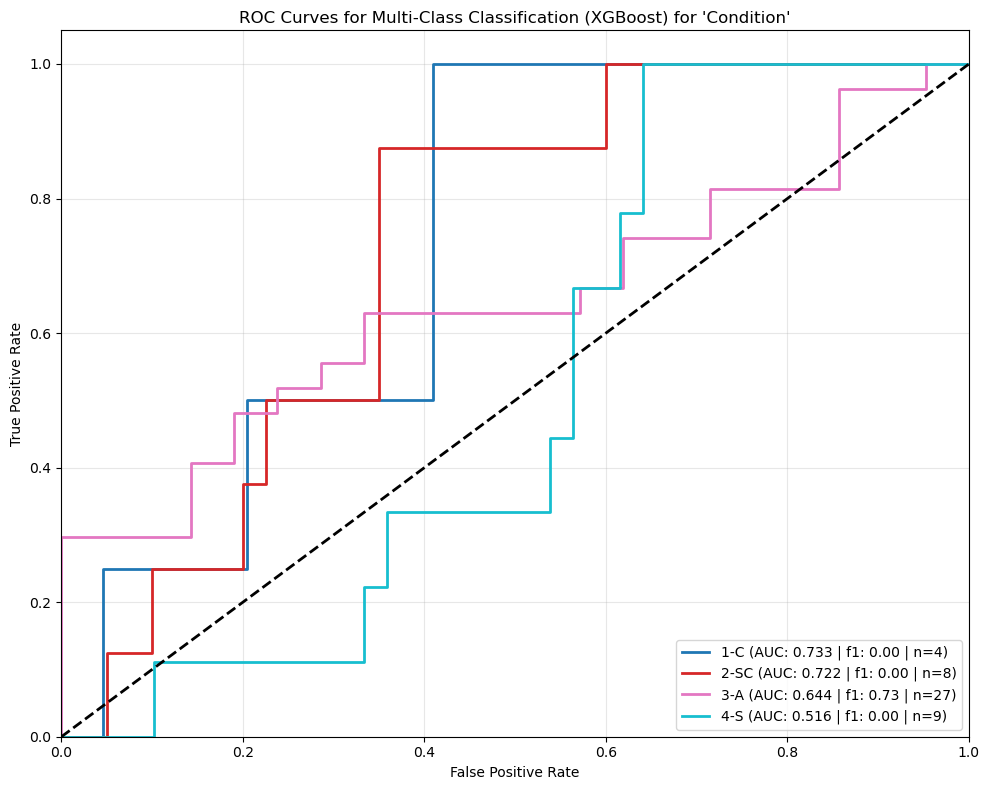

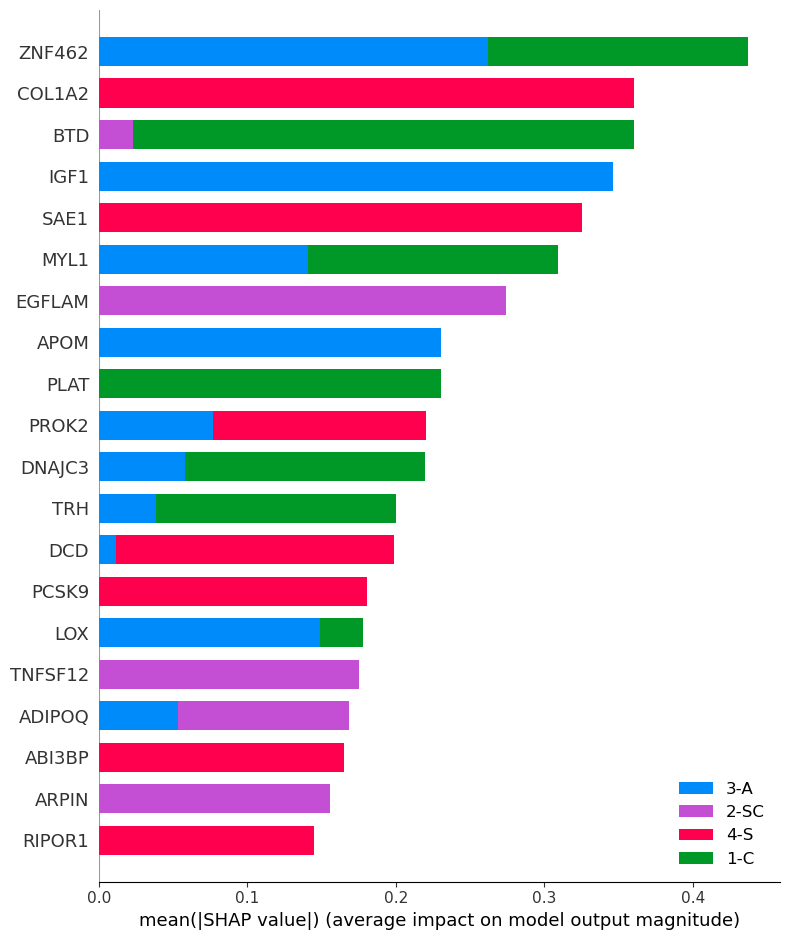

In [ ]:
# protein_group_csv = "protein_group_df.csv"
# clinical_csv = "clinical_df.csv"
# protgroup_gene_map_json = "protgroup_gene_map.json"

# missingness_thresh = 0.2
# imputation_method = "mean"

# seed =42
# var ="Condition"
# protein_group_df = pd.read_csv(protein_group_csv, index_col=0)
# clinical_df = pd.read_csv(clinical_csv, index_col=0)
# protgroup_gene_map = json.load(open("protgroup_gene_map.json"))

# X = protein_group_df
# X = filter_features_by_missingness(X, missingness_thresh)
# X = impute_missing_values(X, imputation_method)
# mapped_series, int_to_value = prepare_categorical_variable(clinical_df, var)

# classify_df = pd.merge(X, mapped_series, left_index=True, right_index=True)
# X_train, X_test, y_train, y_test = split_classify_df(classify_df, var, random_state=seed)
# model = get_multi_class_xgboost_model(X_train, y_train, seed=seed)
# y_prob, y_pred, y_test_binarized = test_model(model, X_test, y_test)

# ovr_auroc = roc_auc_score(y_test_binarized, y_prob, multi_class='ovr')
# report=classification_report(y_test, y_pred,output_dict=True)

# shap_values = get_shap_values(model, X_train, X_test)
# plot_roc_curves(model, y_test_binarized, y_prob, var, int_to_value,report)
# plot_shap_values(shap_values, X_test, model, int_to_value, protgroup_gene_map)
